In [78]:
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import copy
import random
import time 
sys.path.insert(1, '/workspaces/baseline')
from pointcept.datasets.osdar23 import OSDaR23Dataset
from railseg.pcd_processing import pcd_to_las
from pointcept.datasets.transform import PolarMix, Sparsify
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [79]:
annotation_disregarded = -2
learning_map = {
            'background':         0,
            'person':             1,
            'crowd':              1,
            'train':              2,
            'wagons':             2,
            'bicycle':            0,
            'group_of_bicycles':  0,
            'motorcycle':         0,
            'road_vehicle':       3,
            'animal':             0,
            'group_of_animals':   0,
            'wheelchair':         0,
            'drag_shoe':          0,
            'track':              4,
            'transition':         4,
            'switch':             annotation_disregarded,
            'catenary_pole':      5,
            'signal_pole':        6,
            'signal':             6,
            'signal_bridge':      0,
            'buffer_stop':        7,
            'flame':              0,
            'smoke':              0
        }

learning_map_inv = {
            #ignore_index: ignore_index,  # "unlabeled"
            0 : 'background',
            1 : 'person',
            2 : 'train' ,       
            3 : 'road_vehicle',
            4 : 'track',
            5 : 'catenary_pole',
            6 : 'signal',
            7 : 'buffer_stop',
        }

color_map = {#ignore_index:[211, 211, 211],
            0:[211, 211, 211],
            1: [255, 0, 0],  # Person -> Red
            2: [255, 215, 0],# Train -> Yellow
            3: [0, 139, 139],# Road vehicle -> Dark blue
            4: [255, 0, 255],# Track -> Pink
            5: [255, 140, 0],# Catenary_pole -> Orange
            6: [0, 191, 255],# Signal -> Flash blue
            7: [186, 85, 211],# Buffer stop -> Purple
            }

In [141]:
random.seed(32)

data = OSDaR23Dataset(data_root="/workspaces/baseline/data/OSDaR_dataset/v_2", learning_map=learning_map, use_preprocessed=False, return_track_poly3d=True)
rand_int1 = random.randint(0, 1048)

rand_int1 = 50 #240 #50 #230
data_dict, track_dict = data.get_data(rand_int1) # was 140 before


[2024-07-10 13:11:03,772 INFO defaults.py line 58 177674] Totally 1048 x 1 samples in train set.


In [153]:
from shapely.geometry import LineString, Point
from shapely.ops import unary_union
from shapely.ops import nearest_points

# Code taken from https://stackoverflow.com/questions/24415806/coordinates-of-the-closest-points-of-two-geometries-in-shapely

def project_point(point, line):
    # Project one point on the closest location on the line
    point = Point(point)
    return line.interpolate(line.project(point))

def compute_middle_line(left_line, right_line):
    # Given a left and right line with same number of points (in LineString format), 
    # Return the middle line as list of point: [[x1,y1,z1],[x2,y2,z2],...]
    middle_array = []
    for i in range(len(left_line.coords)):
        middle_array.append([(left_line.coords[i][0]+right_line.coords[i][0])/2,
                            (left_line.coords[i][1]+right_line.coords[i][1])/2,
                            (left_line.coords[i][2]+right_line.coords[i][2])/2])
    midline = LineString(middle_array) 
    distances = np.linspace(0, midline.length, 20)
    regular_interval_midline = [list(midline.interpolate(distance).coords[0]) for distance in distances] # 
    
    return regular_interval_midline

def midline_between_polylines(left_rail, right_rail):
    left_line = LineString(left_rail)
    right_line = LineString(right_rail)

    if len(left_line.coords) > len(right_line.coords):
        right_line = LineString([project_point(point, right_line) for point in left_line.coords])
    else: # TODO not sure if I should put an extra cdondition for when the number of points are the same...
        left_line = LineString([project_point(point, left_line) for point in right_line.coords])

    middle_line = compute_middle_line(left_line, right_line)

    return middle_line, left_line, right_line

In [144]:
def predict_track_location(x,y, degree):
    """Goal of this function is to sparsify the track annotations closer to the LiDAR sensor. 
    It evaluates number of points between [end_range-10 ;end_range] and applies the same density for each bucket of 10m before this."""
   
    # Fit a polynomial regression model
    #degree = 2  # You can change the degree based on your needs
    poly = PolynomialFeatures(degree=degree)
    poly_features = poly.fit_transform(x.reshape(-1, 1))
    poly_model = LinearRegression()
    poly_model.fit(poly_features, y)

    # Predict y values for a smooth curve
    x_smooth = np.linspace(x.min(), x.max()+20, 200)
    x_smooth_poly_features = poly.transform(x_smooth.reshape(-1, 1))
    y_smooth = poly_model.predict(x_smooth_poly_features)
    
    return x_smooth, y_smooth

    # y_predicted = poly_model.predict(poly_features)
    # return x, y_predicted
    

In [145]:
# This code was taken from chatGPT. tried to reproduce what they were proposing in "Rail Track Detection and Modelling in Mobile Laser Scanner Data", but not really sure this was what they were doing
from scipy.optimize import curve_fit
def fourier_third_degree(x, a0, a1, a2, a3, b1, b2, b3):
    return a0 + a1 * np.cos(x) + b1 * np.sin(x) + a2 * np.cos(2*x) + b2 * np.sin(2*x) + a3 * np.cos(3*x) + b3 * np.sin(3*x)


def predict_track_location_fourier(x,y):
    initial_guess = (1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0)

    # Fit the Fourier curve
    params, params_covariance = curve_fit(fourier_third_degree, x, y, p0=initial_guess)

    # Define a range of x values for prediction
    x_predict = np.linspace(x.min(), x.max() + 1, 100)

    # Predict y values using the fitted Fourier curve
    y_predict = fourier_third_degree(x_predict, *params)

    return x_predict, y_predict

took : 0.004269838333129883
1.2


/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3508: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


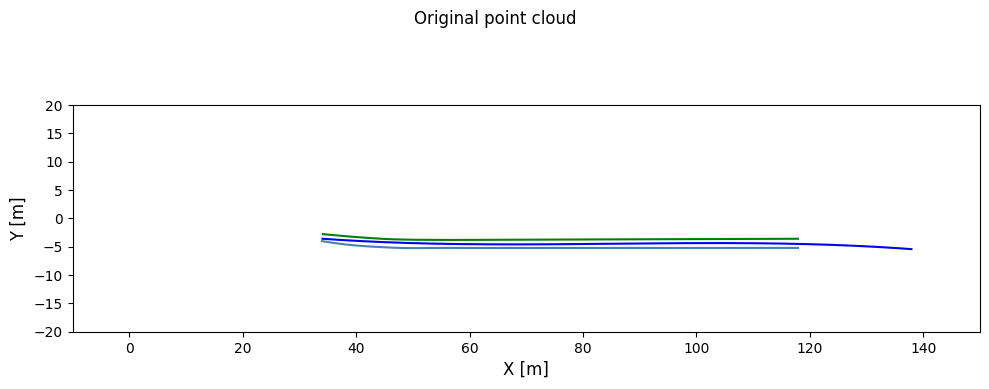

In [154]:
import time
x = data_dict["coord"][:,0]
y = data_dict["coord"][:,1]
c = [np.array(color_map[segmentation])/255 for segmentation in data_dict["segment"]]
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(111)
#scatter = ax.scatter(x, y, c=c, s=0.1)

ax.set_xlim(-10, 150)
ax.set_ylim(-20, 20)
ax.set_aspect('equal')

for key, val in track_dict.items():
    # ax.plot(np.array(track_dict[key]["rightRail"])[:,0],np.array(track_dict[key]["rightRail"])[:,1], "-o", c="steelblue")
    # ax.plot(np.array(track_dict[key]["leftRail"])[:,0],np.array(track_dict[key]["leftRail"])[:,1], "-o", c="green")
    time0 =time.time()
    midline, left_line, right_line = midline_between_polylines(np.array(track_dict[key]["leftRail"]), np.array(track_dict[key]["rightRail"]))
    print("took :", time.time()-time0)
    #ax.plot(np.array(midline)[:,0], np.array(midline)[:,1], "-o", c="red")

    x_pred, y_pred = predict_track_location(np.array(midline)[:,0], np.array(midline)[:,1], degree=3)
    ax.plot(x_pred, y_pred, color='blue', label='Polynomial Fit')
    ax.plot(np.array(left_line)[:,0], np.array(left_line)[:,1],  c="green") #Display the "new" line with same number of point left and right
    ax.plot(np.array(right_line)[:,0], np.array(right_line)[:,1],  c="steelblue")
    break
# for i in range(len(x_y_curve)):
#     ax.plot(x_y_curve[i]["x"], x_y_curve[i]["y"], color='blue', label='Polynomial Fit')
fig.suptitle("Original point cloud")
plt.xlabel('X [m]', fontsize=12)
plt.ylabel('Y [m]', fontsize=12)
fig.tight_layout()
fig.show()
fig.savefig("/workspaces/baseline/exp/temporary_export/predict_track_polylines.jpeg", dpi=300)
#fig.savefig("/workspaces/baseline/exp/temporary_export/predict_track.jpeg", dpi=300)
#plt.close(fig)
#pcd_to_las(np.vstack((data_dict["coord"], midline)), export_path="/workspaces/baseline/exp/temporary_export/visualisation_midline.las", gt_segm=np.hstack((data_dict["segment"], np.full(len(midline), 10))))
print(data_dict["scene"])